In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def export_figure (title):
    plt.tight_layout()
    plt.savefig(os.path.join("figs", title + ".eps"))
    plt.show()

In [3]:
def make_code_columns(raw_coded):
    meta_cols = []
    coder_cols = []
    renamer = {}
    for col in raw_coded.columns:
        shortened = col
        if col[0:3] == "[M]":
            shortened = col[4:-2]
            meta_cols.append(shortened)
        if col[0:3] == "[C]":
            shortened = col[3:]
            coder_cols.append(shortened)
        renamer[col] = shortened


    # first two meta columns are elective code and institution, which we use as the index
    # third meta column is title
    index_cols = meta_cols[0:3]
    keep_cols = index_cols + coder_cols
    base = raw_coded.rename(columns=renamer)[keep_cols]

    long1 = base.melt(index_cols)
    long1.value = long1.value.str.replace(" ","")
    long1.value = long1.value.str.pad(width=2, side='left', fillchar='0')
    long1.value = long1.value.str.replace("00","")

    long2 = long1.join(long1['value'].str.split(';', expand=True))
    long3 = long2.drop('value', axis=1)
    long3 = long3.rename(columns={'variable': 'coder'})

    long4 = long3.melt(index_cols + ['coder'])
    long4 = long4.rename(columns={'value': 'code'})[index_cols + ['coder','code']]
    long4.fillna("",inplace = True)
    long4 = long4[long4.code.str.len()>0]

    long5 = long4.groupby(index_cols + ['code']).count().unstack().fillna(0)
    long5.columns = long5.columns.get_level_values(1)
    return long5



In [4]:
def has_agreement_inset_code(code_in_columns, value_set, code):
    return code_in_columns[code].isin(value_set)

def has_agreement_inset_any_code(code_in_columns, value_set):
    has_agreement = False
    for col in code_in_columns.columns:
        has_agreement = has_agreement | has_agreement_inset_code(code_in_columns, value_set, col)
    return has_agreement

def has_agreement_4_plus_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [4,5,6,7], code)

def has_agreement_23_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [2,3], code)

def has_agreement_3_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [3], code)

def has_agreement_4_plus_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [4,5,6,7])

def has_agreement_23_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [2,3])

def has_agreement_3_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [3])

def has_good_overall_agreement_code(code_in_columns, code):
    return (has_agreement_4_plus_code(code_in_columns, code)) & ~(has_agreement_23_code(code_in_columns, code))

def has_good_overall_agreement_any_code(code_in_columns):
    return (has_agreement_4_plus_any_code(code_in_columns)) & ~(has_agreement_23_any_code(code_in_columns))

def has_some_overall_agreement_code(code_in_columns, code):
    return (has_agreement_4_plus_code(code_in_columns, code)) & ~(has_agreement_3_code(code_in_columns, code))

def has_some_overall_agreement_any_code(code_in_columns):
    return (has_agreement_4_plus_any_code(code_in_columns)) & ~(has_agreement_3_any_code(code_in_columns))


In [5]:
#dump_file = "20230612WG6_Trial_Sample50-export-20230616-013559.csv"
#dump_file = "20230622WG6_AllElectivesPart1-export-20230702-050135.csv"
#dump_file = "20230622WG6_AllElectivesPart2-export-20230702-050210.csv"
#dump_file = "20230622WG6_AllElectivesPart1-export-20230705-123616.csv"
stage_one_files = ["20230622WG6_AllElectivesPart1-stage1.csv", "20230622WG6_AllElectivesPart2-stage1.csv", "20230622WG6_AllElectivesPart3-stage1.csv"]

stage_one_contents = []
for stage_one_file in stage_one_files:
    raw = pd.read_csv(os.path.join("coded", stage_one_file), dtype='string').fillna("")
    raw = raw.replace("Edinburgh_UK", "Edinburgh_Scotland")
    stage_one_contents.append(raw)
raw_coded = pd.concat(stage_one_contents)
raw_coded.to_csv(os.path.join("coded","stage1_codes_raw.csv"))

code_in_columns = make_code_columns(raw_coded)
code_in_columns.to_csv(os.path.join("coded","stage1_codes_columns.csv"))


In [6]:
stage_two = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"))

key_columns = ['institution', 'elective']
print(len(stage_two.columns))
stage_two_files = ["stage2_codes_columns-DM.csv",
                   "stage2_codes_columns-SDF.csv",
                   "stage2_codes_columns-AL.csv",
                   "stage2_codes_columns-SE-SP.csv",
                   "stage2_codes_columns-SPD.csv",
                   "stage2_codes_columns-FPL.csv",
                   "stage2_codes_columns-MSF.csv",
                   "stage2_codes_columns-GIT.csv",
                   "stage2_codes_columns-CAH.csv",
                   "stage2_codes_columns-OS.csv",
                   "stage2_codes_columns-AI.csv",
                   "stage2_codes_columns-A.csv",
                   "stage2_codes_columns-SEC.csv"]
for stage_two_file in stage_two_files:
    stage_two_addition = pd.read_csv(os.path.join("coded", "stage2", stage_two_file), dtype='string').fillna("")
    updated_columns = list(set(stage_two_addition.columns) - set(key_columns))
    print (updated_columns, "updated columns for ", stage_two_file)
    joined = stage_two.merge(stage_two_addition, on=['institution','elective'], how='left')
    for updated_column in updated_columns:
        joined[updated_column] = joined[updated_column+"_y"].astype('float')*7
        joined.drop(columns=[updated_column + "_x", updated_column + "_y"], inplace=True)
    stage_two = joined.fillna(0)
#    print(joined.describe())
    
stage_two.to_csv(os.path.join("coded","stage2_codes_columns.csv"))

38
['DM'] updated columns for  stage2_codes_columns-DM.csv
['SDF'] updated columns for  stage2_codes_columns-SDF.csv
['AL'] updated columns for  stage2_codes_columns-AL.csv
['SE', 'SEP'] updated columns for  stage2_codes_columns-SE-SP.csv
['SPD'] updated columns for  stage2_codes_columns-SPD.csv
['FPL'] updated columns for  stage2_codes_columns-FPL.csv
['MSF'] updated columns for  stage2_codes_columns-MSF.csv
['GIT'] updated columns for  stage2_codes_columns-GIT.csv
['18', '14', '02', '10', '21', '22', '17', '15', '09', '13', '03', '19', '01', '24', '16', '07', '08', '04'] updated columns for  stage2_codes_columns-CAH.csv
['OS'] updated columns for  stage2_codes_columns-OS.csv
['AI'] updated columns for  stage2_codes_columns-AI.csv
['AR'] updated columns for  stage2_codes_columns-AR.csv
['SEC'] updated columns for  stage2_codes_columns-SEC.csv


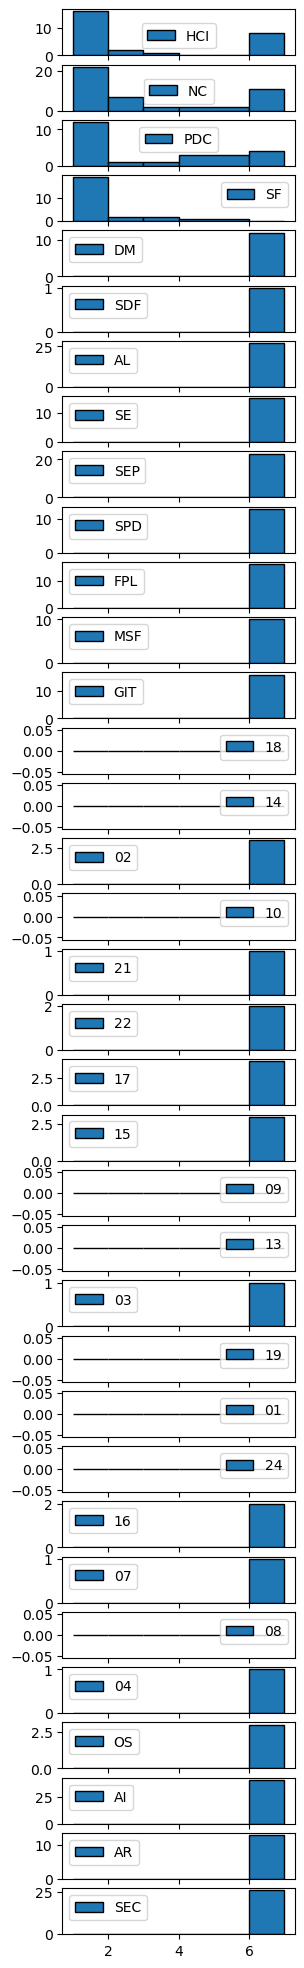

In [7]:
cols_to_plot = stage_two.columns[3:]

fig, axs = plt.subplots(len(cols_to_plot), figsize=(3, 25))
for n, col in enumerate(cols_to_plot):
    stage_two[col].replace(0, np.nan).hist(ax=axs[n], bins=[1,2,3,4,6,7],  edgecolor='black', grid=False, legend=True)



Suggestions for more stage 2 coding: 
* AI
* MSF
* FPL

Still some CAH data to come, but possibly
* 22 (education)
* 15 (social sciences)
* 14 (humanities and libreal arts)


In [8]:
stage_two[~has_good_overall_agreement_any_code(stage_two)]

,elective,institution,title,HCI,NC,PDC,SF,DM,SDF,AL,...,01,24,16,07,08,04,OS,AI,AR,SEC
0,1DL034,Uppsala_Sweden,Introduction to Machine Learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
1,1DL231,Uppsala_Sweden,Algorithms and Data Structures II,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1DL311,Uppsala_Sweden,Semantics of Programming Languages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1DT075,Uppsala_Sweden,Cryptology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
4,1TD062,Uppsala_Sweden,High Performance Programming,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,inf-EAeS,CAU_Germany,Methods for Efficient Similarity Search in Lar...,0.0,0.0,0.0,0.0,7.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,inf-EERP,CAU_Germany,Implementation of ERP systems,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,inf-EnlOpt,CAU_Germany,Introduction to Nonlinear Optimization,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,inf-IoT,CAU_Germany,Internet of Things and Wireless Networks,0.0,5.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
stage_two[~has_some_overall_agreement_any_code(stage_two)]

,elective,institution,title,HCI,NC,PDC,SF,DM,SDF,AL,...,01,24,16,07,08,04,OS,AI,AR,SEC
6,22.4,UOC_Spain,Computational thinking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,5.587,UOC_Spain,Software engineering of components and distrib...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,5.597,UOC_Spain,Information systems integration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,5.613,UOC_Spain,Data structures design,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,COMP3617,Durham_England,COMP3617: VIRTUAL AND AUGMENTED REALITY,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,cxinfr11215,Edinburgh_Scotland,Undergraduate Course: Knowledge Graphs (INFR11...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,cxinfr11217,Edinburgh_Scotland,Undergraduate Course: Advanced Database System...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,cxinfr11218,Edinburgh_Scotland,Undergraduate Course: Algorithmic Game Theory ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,cxinfr11240,Edinburgh_Scotland,Undergraduate Course: Privacy and Security wit...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
stage_two[~has_agreement_4_plus_any_code(stage_two)]

,elective,institution,title,HCI,NC,PDC,SF,DM,SDF,AL,...,01,24,16,07,08,04,OS,AI,AR,SEC
6,22.4,UOC_Spain,Computational thinking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,5.597,UOC_Spain,Information systems integration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,5.613,UOC_Spain,Data structures design,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,CS3824,VirginiaTech_USA,Introduction to Computational Biology and Bioi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,CS4234,VirginiaTech_USA,Parallel Computation,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,cxinfr11215,Edinburgh_Scotland,Undergraduate Course: Knowledge Graphs (INFR11...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,cxinfr11217,Edinburgh_Scotland,Undergraduate Course: Advanced Database System...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,cxinfr11218,Edinburgh_Scotland,Undergraduate Course: Algorithmic Game Theory ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,cxinfr11240,Edinburgh_Scotland,Undergraduate Course: Privacy and Security wit...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
def electives_with_codes(codes):
    code_in_columns = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"))
    has_a_code = False
    for code in codes:
        has_a_code = has_a_code | (code_in_columns[code] > 0)
    index_of_electives_with_code = code_in_columns[has_a_code][['institution','elective','title']]
    def row_included(row):
        this_inst = row.institution
        this_elective = row.elective
        return index_of_electives_with_code[(index_of_electives_with_code.institution == this_inst) &
                                           (index_of_electives_with_code.elective == this_elective)]['elective'].count() >0
    all_electives = pd.read_csv("all_electives.csv")
    return all_electives[all_electives.apply(row_included, axis=1)]
#    return all_electives.apply(row_included, axis=1)

In [13]:
DM = electives_with_codes(["DM"])
DM

,institution,elective,overview,title,summary,content,ilo
4,Durham_England,COMP3491,<h2>Durham_England COMP3491</h2><h2>title</h2>...,COMP3491: \nCODES AND CRYPTOGRAPHY,\n\t\t\t<li>To give an introduction to the fun...,\n\t\t\t<li>Data compression: lossless compres...,"\n\t\t\t\t<li>On completion of the module, stu..."
6,Durham_England,COMP3517,<h2>Durham_England COMP3517</h2><h2>title</h2>...,COMP3517: \nCOMPUTATIONAL MODELLING IN THE HUM...,\n\t\t\t<li>To enable students to understand a...,\n\t\t\t<li>Computational models of text and l...,"\n\t\t\t\t<li>On completion of the module, stu..."
27,Durham_England,COMP4157,<h2>Durham_England COMP4157</h2><h2>title</h2>...,COMP4157: \nLEARNING ANALYTICS,\n\t\t\t<li>To give students a fundamental und...,\n\t\t\t<li>Statistical Learning Analytics and...,\n\t\t\t\t<li>The key principles and methodolo...
29,Durham_England,COMP4177,<h2>Durham_England COMP4177</h2><h2>title</h2>...,COMP4177: \nNETWORKS AND THEIR STRUCTURE,\n\t\t\t<li>To design structured networks to p...,\n\t\t\t<li>Core aspects of interconnection ne...,"\n\t\t\t\t<li>On completion of the module, stu..."
34,Edinburgh_Scotland,cxinfr08033,<h2>Edinburgh_Scotland cxinfr08033</h2><h2>tit...,Undergraduate Course: Informatics Experiential...,NaN,Informatics Experiential Learning is available...,NaN
44,Edinburgh_Scotland,cxinfr10080,<h2>Edinburgh_Scotland cxinfr10080</h2><h2>tit...,Undergraduate Course: Introduction to Database...,Data is one of the most important assets of an...,\n \n Databases encompass many areas of ...,NaN
45,Edinburgh_Scotland,cxinfr10084,<h2>Edinburgh_Scotland cxinfr10084</h2><h2>tit...,Undergraduate Course: Informatics Experiential...,NaN,Informatics Experiential Learning is available...,NaN
55,Edinburgh_Scotland,cxinfr11088,<h2>Edinburgh_Scotland cxinfr11088</h2><h2>tit...,Postgraduate Course: Extreme Computing (INFR11...,"Extreme Computing deals with the principles, s...",\n \n The course is to be conceptually s...,NaN
65,Edinburgh_Scotland,cxinfr11145,<h2>Edinburgh_Scotland cxinfr11145</h2><h2>tit...,Undergraduate Course: Text Technologies for Da...,This course teaches the basic technologies req...,\n \n Syllabus:<br>\n* Introduction to I...,NaN
70,Edinburgh_Scotland,cxinfr11199,<h2>Edinburgh_Scotland cxinfr11199</h2><h2>tit...,Undergraduate Course: Advanced Database System...,Database management systems are at the core of...,\n \n Lectures will cover roughly the fo...,NaN
